   x [GeV] |      y (Entries/GeV)
---------------------------------
     22.83 |         8.388908e+01
     27.80 |         2.255797e+01
     32.77 |         6.633332e+00
     37.41 |         2.085125e-01
     42.55 |         2.097131e-01


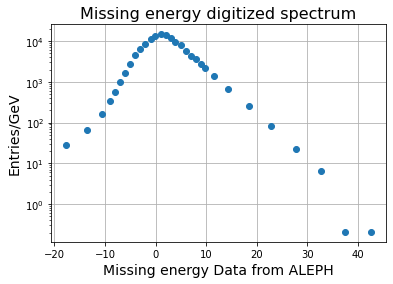

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load and prepare data ---
data = np.genfromtxt("Dataset_ALEPH.txt", delimiter=';', dtype=str)
data = np.char.replace(data, ',', '.').astype(float)

x = data[:, 0]  # Missing energy [GeV]
y = data[:, 1]  # Entries/GeV

y_norm = y / np.sum(y)

# --- Filter and print table for x > 20 ---
mask = x > 20
print(f"{'x [GeV]':>10} | {'y (Entries/GeV)':>20}")
print("-" * 33)
for xi, yi in zip(x[mask], y[mask]):
    print(f"{xi:10.2f} | {yi:20.6e}")

obs_counts = np.array([420, 113, 31, 1, 1])   # counts
obs_errors = np.sqrt(obs_counts)              # Poisson errors


# --- Plot ---
plt.yscale("log")
plt.plot(x, y, 'o')
plt.xlabel("Missing energy Data from ALEPH", fontsize=14)
plt.ylabel("Entries/GeV", fontsize=14)
plt.title("Missing energy digitized spectrum", fontsize=16)
plt.grid(True)
plt.show()


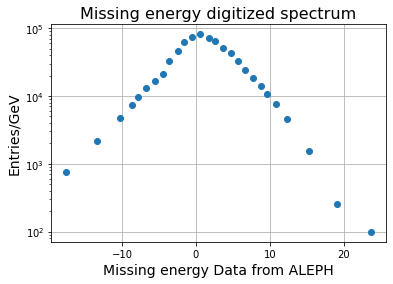

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt("background_data.txt", delimiter=';', dtype=str)
data = np.char.replace(data, ',', '.').astype(float)
    
x_bg = data[:, 0]  # Missing energy [GeV]
y_bg = data[:, 1]  # Entries/GeV

y_bg_norm = y_bg / np.sum(y_bg)

plt.yscale("log")
plt.plot(x_bg, y_bg,'o')
plt.xlabel("Missing energy Data from ALEPH", fontsize = 14)
plt.ylabel("Entries/GeV", fontsize = 14)
plt.title("Missing energy digitized spectrum", fontsize = 16)
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# NORMALIZED BACKGROUND COMPARISON

def plot_missing_energy_normalization(thrust_summary_path, lepton_summary_path, selected_summary_path, bins=np.linspace(-50, 47, 80)):
    """
    Compare missing energy distributions:
      - Hemisphere-level (thrust, lepton cuts)
      - Event-level (thrust, lepton cuts)
      - Selected hemispheres (signal-like, ALEPH digitized)
    """

    # --- Load hemisphere data ---
    thrust_data = np.genfromtxt(thrust_summary_path, delimiter=",", names=True)
    lepton_data = np.genfromtxt(lepton_summary_path, delimiter=",", names=True)

    # Hemisphere missing energies
    E_miss_thrust = thrust_data["E_miss"]
    E_miss_lepton = lepton_data["E_miss"]

    # --- Event-level: sum hemispheres per event ---
    df_thrust = pd.read_csv(thrust_summary_path, sep=",")
    df_lepton = pd.read_csv(lepton_summary_path, sep=",")

    E_miss_thrust_event = df_thrust.groupby("event_id")["E_miss"].sum().values
    E_miss_lepton_event = df_lepton.groupby("event_id")["E_miss"].sum().values

    # --- Load selected hemispheres (signal-like) ---
    sel_data = np.genfromtxt(selected_summary_path, delimiter=",", names=True)
    E_miss_sig = np.where(
        sel_data["E_miss_h1"] > sel_data["E_miss_h2"],
        sel_data["E_miss_h1"],
        sel_data["E_miss_h2"]
    )

    # Count signal region
    in_region = ((E_miss_sig >= 35) & (E_miss_sig <= 45.6))
    print("Selected hemispheres in [35,46] GeV:", np.sum(in_region))

    # --- Histograms ---
    counts_thrust, bin_edges = np.histogram(E_miss_thrust, bins=bins)
    counts_lepton, _         = np.histogram(E_miss_lepton, bins=bins)
    counts_thrust_event, _   = np.histogram(E_miss_thrust_event, bins=bins)
    counts_lepton_event, _   = np.histogram(E_miss_lepton_event, bins=bins)

    # Normalize
    counts_thrust_norm       = counts_thrust       / np.sum(counts_thrust)
    counts_lepton_norm       = counts_lepton       / np.sum(counts_lepton)
    counts_thrust_event_norm = counts_thrust_event / np.sum(counts_thrust_event)
    counts_lepton_event_norm = counts_lepton_event / np.sum(counts_lepton_event)

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # --- Plot ---
    plt.figure(figsize=(8,6))

    # Hemisphere-level
    plt.step(bin_centers, counts_thrust_norm, where="mid",
             color="pink", linewidth=1.5, label="Thrust cuts (hemispheres, norm.)")
    plt.step(bin_centers, counts_lepton_norm, where="mid",
             color="gray", linewidth=1.5, label="Thrust+lepton cuts (hemispheres, norm.)")

    # ALEPH digitized 
    plt.scatter(x, y_norm, color="k", marker="o", label="ALEPH (signal, norm)")
    
    plt.scatter(x_bg, y_bg_norm, color="blue", marker="o", label="ALEPH (background, norm.)")

    # Formatting
    plt.yscale("log")
    plt.xlim(-20, 45)
    plt.xlabel(r"$E_{\rm miss}$ [GeV]", fontsize=14)
    plt.ylabel("Normalized Entries", fontsize=14)
    plt.title("Missing Energy Distribution (normalized)", fontsize=15)
    plt.legend()

    # Highlight ALEPH signal region [35,45.6]
    plt.axvline(34.7, color="black", linestyle="--", linewidth=1)
    plt.axvline(45.6, color="black", linestyle="--", linewidth=1)
    plt.text(38, 1e-3, "Signal region", rotation=90, fontsize=12, va="bottom")

    plt.show()


Selected hemispheres in [35,46] GeV: 12


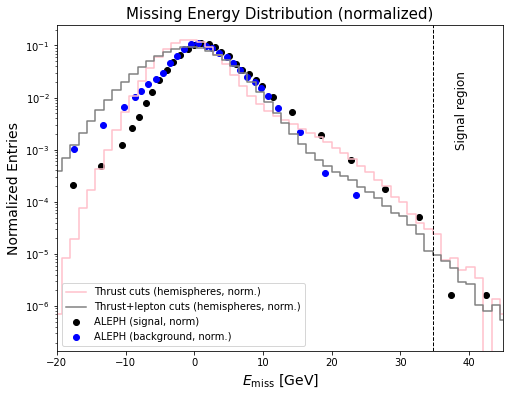

In [9]:
plot_missing_energy_normalization("all_hemispheres_HEtail.csv", "background_smeared.csv", "summary_alephHE_tail.csv", bins=np.linspace(-50, 47, 80))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DIRECT BACKGROUND COMPARISON

def plot_missing_energy_distribution(thrust_summary_path, lepton_summary_path, selected_summary_path):
    """
    Compare missing energy distributions:
      - Hemisphere-level (thrust, lepton cuts)
      - Event-level (thrust, lepton cuts)
      - Selected hemispheres (signal-like)
      - ALEPH digitized (x,y must be defined externally)
    """

    # --- ALEPH-style variable binning ---
    bins = np.array([
    -20, -16, -12, -10, -8, -6, -5, -4, -3, -2, -1,   
      0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,   
     13, 16, 20,                                
     25, 30, 35, 40, 45                            
    ])

    # --- Load hemisphere data ---
    thrust_data = np.genfromtxt(thrust_summary_path, delimiter=",", names=True)
    lepton_data = np.genfromtxt(lepton_summary_path, delimiter=",", names=True)

    E_miss_thrust = thrust_data["E_miss"]
    E_miss_lepton = lepton_data["E_miss"]

    # --- Event-level sums ---
    df_thrust = pd.read_csv(thrust_summary_path, sep=",")
    df_lepton = pd.read_csv(lepton_summary_path, sep=",")

    E_miss_thrust_event = df_thrust.groupby("event_id")["E_miss"].sum().values
    E_miss_lepton_event = df_lepton.groupby("event_id")["E_miss"].sum().values

    # --- Load selected hemispheres (signal-like) ---
    sel_data = np.genfromtxt(selected_summary_path, delimiter=",", names=True)
    E_miss_sig = np.where(
        sel_data["E_miss_h1"] > sel_data["E_miss_h2"],
        sel_data["E_miss_h1"],
        sel_data["E_miss_h2"]
    )

    in_region = ((E_miss_sig >= 35) & (E_miss_sig <= 45.6))
    print("Selected hemispheres in [35,46] GeV:", np.sum(in_region))

    # --- Histograms with ALEPH bins ---
    counts_thrust, _       = np.histogram(E_miss_thrust, bins=bins)
    counts_lepton, _       = np.histogram(E_miss_lepton, bins=bins)
    counts_thrust_event, _ = np.histogram(E_miss_thrust_event, bins=bins)
    counts_lepton_event, _ = np.histogram(E_miss_lepton_event, bins=bins)
    counts_sig, _          = np.histogram(E_miss_sig, bins=bins)

    # --- Normalize by bin widths ---
    bin_widths = np.diff(bins)
    counts_thrust_density       = counts_thrust       / bin_widths
    counts_lepton_density       = counts_lepton       / bin_widths
    counts_thrust_event_density = counts_thrust_event / bin_widths
    counts_lepton_event_density = counts_lepton_event / bin_widths
    counts_sig_density          = counts_sig          / bin_widths

    # --- Plot ---
    plt.figure(figsize=(8,6))

    plt.step(bins, np.append(counts_thrust_density, 0), where="post",
             color="pink", linewidth=1.5, label="Thrust cuts (hemispheres)")
    plt.step(bins, np.append(counts_lepton_density, 0), where="post",
             color="gray", linewidth=1.5, label="Thrust+lepton cuts (hemispheres)")

    plt.step(bins, np.append(counts_sig_density, 0), where="post",
             color="blue", linewidth=1.5, label="Selected hemispheres")

    # ALEPH digitized (defined externally: x, y)
    plt.scatter(x, y, color="k", marker="o", label="ALEPH (signal)")
    
    plt.scatter(x_bg, y_bg, color="blue", marker="o", label="ALEPH (background)")

    # Formatting
    plt.yscale("log")
    plt.xlim(-20, 45)
    plt.xlabel(r"$E_{\rm miss}$ [GeV]", fontsize=14)
    plt.ylabel("Entries / GeV", fontsize=14)
    plt.title("Missing Energy Distribution", fontsize=15)
    plt.legend()

    # Highlight ALEPH signal region [35,45.6]
    plt.axvline(35, color="black", linestyle="--", linewidth=1)
    plt.axvline(45.6, color="black", linestyle="--", linewidth=1)
    plt.text(38, 1e3, "Signal region", rotation=90, fontsize=12, va="bottom")

    plt.show()


Selected hemispheres in [35,46] GeV: 12


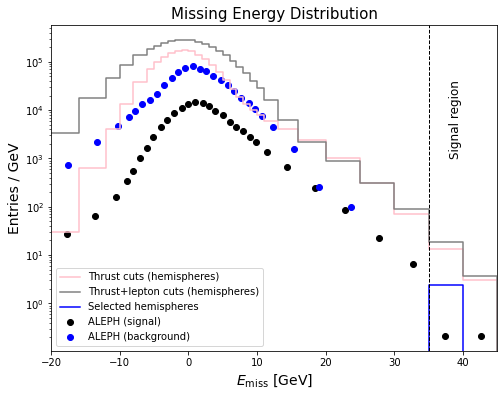

In [11]:
plot_missing_energy_distribution("all_hemispheres_HEtail.csv", "background_smeared.csv", "summary_alephHE_tail.csv")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DIRECT SIGNAL COMPARISON

def after_cuts_distribution(background_csv, signal_csv,
                              x_min, x_max):
    """
    Plot background (hemisphere vs event level) vs selected signal hemispheres,
    focusing on the high-energy tail, with ALEPH-style 5 GeV binning.
    """
    bins = np.array([
    -20, -16, -12, -10, -8, -6, -5, -4, -3, -2, -1,   
      0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,   
     13, 16, 20,                                
     25, 30, 35, 40, 45                            
    ])

    # Bin widths are not constant now!
    bin_widths = np.diff(bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # --- Load data ---
    bg = pd.read_csv(background_csv)
    sig = pd.read_csv(signal_csv)

    # Hemisphere-level background
    E_miss_bg_hemi = np.concatenate([bg["E_miss_h1"].values,
                                     bg["E_miss_h2"].values])

    # Selected hemisphere (larger missing E)
    E_miss_sig = np.where(sig["E_miss_h1"].values > sig["E_miss_h2"].values,
                          sig["E_miss_h1"].values, sig["E_miss_h2"].values)
    
    # Histograms

    counts_bg_hemi, _ = np.histogram(E_miss_bg_hemi, bins=bins)
    counts_sig, _     = np.histogram(E_miss_sig, bins=bins)
    
    # Normalize to Entries/GeV

    counts_bg_hemi = counts_bg_hemi / bin_widths
    counts_sig     = counts_sig / bin_widths

    # --- Force step to extend to the last bin edge ---
    # Append a zero to make sure the line goes to the end
    counts_bg_hemi_plot = np.append(counts_bg_hemi, 0)
    counts_sig_plot = np.append(counts_sig, 0)
    bin_edges_for_plot = bins  # already includes the last edge (45)
    
    # --- Plot ---
    plt.figure(figsize=(8,6))
    
    # Background

    plt.step(bin_edges_for_plot, counts_bg_hemi_plot, where="post",
         color="pink", linewidth=1.5, label="Simulation")
    
    # Signal

    plt.step(bin_edges_for_plot, counts_sig_plot, where="post",
         color="blue", linewidth=1.5, label="Signal hemispheres")

    # ALEPH digitized points (optional)
    plt.scatter(x, y, color="k", marker="o", label="ALEPH (digitized)")
   
    # Formatting
    
    # Highlight ALEPH signal region [35,45.6]
    plt.axvline(35, color="black", linestyle="--", linewidth=1)
    plt.axvline(45.6, color="black", linestyle="--", linewidth=1)
    plt.text(38, 1e1, "ALEPH signal region", rotation=90, fontsize=12, va="bottom")
    
    plt.yscale("log")
    plt.xlim(x_min, x_max)   # zoom to high-energy tail
    plt.xlabel(r"$E_{\rm miss}$ [GeV]", fontsize=16)
    plt.ylabel("Entries / GeV", fontsize=16)
    plt.title(r"Missing energy distribution", fontsize=18)
    plt.legend()
    plt.tight_layout()
    #plt.savefig("High energy tail.png")
    plt.show()


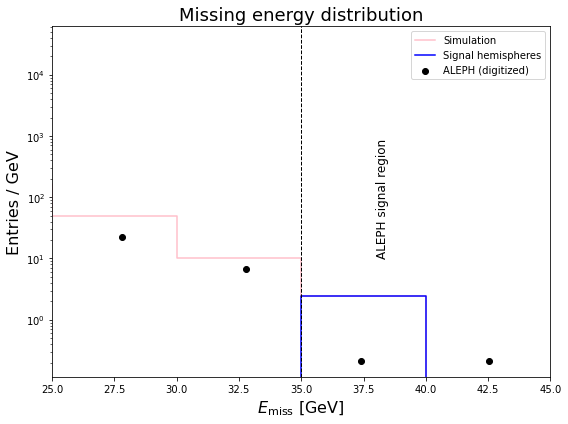

In [18]:
after_cuts_distribution("summary_aleph_all.csv", 
                        "summary_alephHE_tail.csv", x_min=25, x_max=45) 

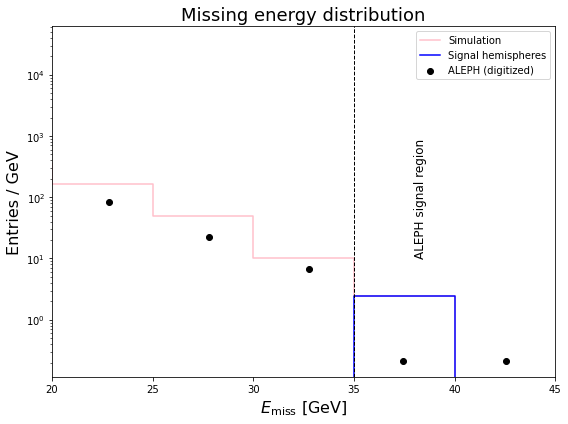

In [19]:
after_cuts_distribution("summary_aleph_all.csv", 
                        "summary_alephHE_tail.csv", x_min=20, x_max=45)


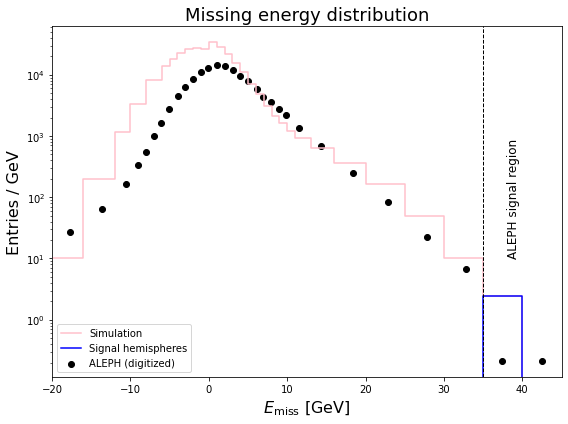

In [20]:
after_cuts_distribution("summary_aleph_all.csv", 
                        "summary_alephHE_tail.csv", x_min=-20, x_max=45)  


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DIRECT SIGNAL COMPARISON (WITH UNCERTAINTIES) 

def after_cuts_distribution(background_csv, signal_csv,
                            x_min, x_max):
    """
    Plot background vs selected signal hemispheres,
    focusing on the high-energy tail, with ALEPH-style 5 GeV binning.
    """

    bins = np.array([
        -20, -16, -12, -10, -8, -6, -5, -4, -3, -2, -1,
         0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        13, 16, 20,
        25, 30, 35, 40, 45
    ])

    # Bin widths are not constant now!
    bin_widths = np.diff(bins)

    # --- Load data ---
    bg = pd.read_csv(background_csv)
    sig = pd.read_csv(signal_csv)

    # Hemisphere-level background
    E_miss_bg_hemi = np.concatenate([bg["E_miss_h1"].values,
                                     bg["E_miss_h2"].values])

    # Selected hemisphere (larger missing E)
    E_miss_sig = np.where(sig["E_miss_h1"].values > sig["E_miss_h2"].values,
                          sig["E_miss_h1"].values, sig["E_miss_h2"].values)

    # Histograms
    counts_bg_hemi, _ = np.histogram(E_miss_bg_hemi, bins=bins)
    counts_sig, _     = np.histogram(E_miss_sig, bins=bins)

    # Normalize to Entries/GeV
    counts_bg_hemi = counts_bg_hemi / bin_widths
    counts_sig     = counts_sig / bin_widths

    # --- Prepare step plots ---
    counts_bg_hemi_plot = np.append(counts_bg_hemi, 0)
    counts_sig_plot     = np.append(counts_sig, 0)
    bin_edges_for_plot  = bins

    # --- Plot ---
    plt.figure(figsize=(8,6))

    # Background
    plt.step(bin_edges_for_plot, counts_bg_hemi_plot, where="post",
             color="pink", linewidth=1.5, label="Simulation")

    # Signal
    plt.step(bin_edges_for_plot, counts_sig_plot, where="post",
             color="blue", linewidth=1.5, label="Signal hemispheres")

    # --- ALEPH official 5-bin counts ---
    obs_counts = np.array([420, 113, 31, 1, 1])   # counts in [20-25,...,40-45]
    obs_errors = np.sqrt(obs_counts)
    bin_centers_ALEPH = np.array([22.5, 27.5, 32.5, 37.5, 42.5])
    bin_widths_ALEPH = 5.0

    # Normalize to Entries/GeV
    obs_vals = obs_counts / bin_widths_ALEPH
    obs_errs = obs_errors / bin_widths_ALEPH

    plt.errorbar(bin_centers_ALEPH, obs_vals, yerr=obs_errs,
                 fmt="o", color="k", label="ALEPH (data)", capsize=3)

    # Formatting
    plt.axvline(35, color="black", linestyle="--", linewidth=1)
    plt.axvline(45.6, color="black", linestyle="--", linewidth=1)
    plt.text(38, 1e1, "ALEPH signal region", rotation=90,
             fontsize=12, va="bottom")

    plt.yscale("log")
    plt.xlim(x_min, x_max)
    plt.xlabel(r"$E_{\rm miss}$ [GeV]", fontsize=16)
    plt.ylabel("Entries / GeV", fontsize=16)
    plt.title(r"Missing energy distribution", fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig("High_energy_tail.png")
    plt.show()


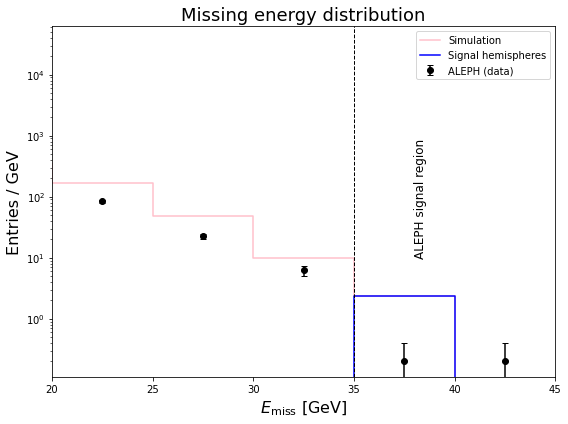

In [22]:
after_cuts_distribution("summary_aleph_all.csv", 
                        "summary_alephHE_tail.csv", x_min=20, x_max=45)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# DIRECT SIGNAL COMPARISON (WITH UNCERTAINTIES) + BSM
def after_cuts_distributionBSM(background_csv, signal_csv,
                               x_min, x_max):
    """
    Plot background vs selected signal hemispheres + BSM with branching ratio of 1
    focusing on the high-energy tail, with ALEPH-style binning. 
    Adds Poisson uncertainties to the simulation and the BSM data.
    """
    # --- BSM counts in the last 6 bins (exclusive bins)
    BSM_counts = np.array([10837, 8974, 6366, 2445, 219, 0])

    bins = np.array([
        -20, -16, -12, -10, -8, -6, -5, -4, -3, -2, -1,
         0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
        13, 16, 20,
        25, 30, 35, 40, 45
    ])
    bin_widths = np.diff(bins)

    # Select the last 6 bins
    last6_bins = bins[-6:]
    last6_widths = bin_widths[-6:]

    # --- Load data ---
    bg = pd.read_csv(background_csv)
    sig = pd.read_csv(signal_csv)

    # Hemisphere-level background
    E_miss_bg_hemi = np.concatenate([bg["E_miss_h1"].values,
                                     bg["E_miss_h2"].values])

    # Selected hemisphere (larger missing E)
    E_miss_sig = np.where(sig["E_miss_h1"].values > sig["E_miss_h2"].values,
                          sig["E_miss_h1"].values, sig["E_miss_h2"].values)

    # --- Histograms ---
    counts_bg_hemi, _ = np.histogram(E_miss_bg_hemi, bins=bins)
    counts_sig, _     = np.histogram(E_miss_sig, bins=bins)

    # Poisson errors before normalization
    errs_bg_hemi = np.sqrt(counts_bg_hemi) / bin_widths
    errs_sig     = np.sqrt(counts_sig) / bin_widths
    errs_BSM     = np.sqrt(BSM_counts) / last6_widths

    # Normalize counts to Entries/GeV
    counts_bg_hemi = counts_bg_hemi / bin_widths
    counts_sig     = counts_sig / bin_widths
    counts_BSM     = BSM_counts / last6_widths

    # --- Prepare step plots ---
    counts_bg_hemi_plot = np.append(counts_bg_hemi, 0)
    counts_sig_plot     = np.append(counts_sig, 0)
    bin_edges_for_plot  = bins

    # --- Plot ---
    plt.figure(figsize=(8,6))

    # Background
    plt.step(bin_edges_for_plot, counts_bg_hemi_plot, where="post",
             color="pink", linewidth=1.5, label="Simulation")
    plt.errorbar((bins[:-1] + bins[1:]) / 2, counts_bg_hemi, yerr=errs_bg_hemi,
                 fmt="none", ecolor="pink", alpha=0.7, capsize=2)

    # Signal
    plt.step(bin_edges_for_plot, counts_sig_plot, where="post",
             color="blue", linewidth=1.5, label="Signal hemispheres")
    plt.errorbar((bins[:-1] + bins[1:]) / 2, counts_sig, yerr=errs_sig,
                 fmt="none", ecolor="blue", alpha=0.7, capsize=2)

    # BSM
    plt.step(last6_bins, counts_BSM, where="post",
             color="gray", linestyle='--', linewidth=1.5, label="BSM with BR = 1")

    # --- ALEPH official 5-bin counts ---
    obs_counts = np.array([420, 113, 31, 1, 1])   # counts in [20-25,...,40-45]
    obs_errors = np.sqrt(obs_counts)
    bin_centers_ALEPH = np.array([22.5, 27.5, 32.5, 37.5, 42.5])
    bin_widths_ALEPH = 5.0

    # Normalize to Entries/GeV
    obs_vals = obs_counts / bin_widths_ALEPH
    obs_errs = obs_errors / bin_widths_ALEPH

    plt.errorbar(bin_centers_ALEPH, obs_vals, yerr=obs_errs,
                 fmt="o", color="k", label="ALEPH (data)", capsize=3)

    # Formatting
    plt.axvline(35, color="black", linestyle="--", linewidth=1)
    plt.axvline(45.6, color="black", linestyle="--", linewidth=1)
    plt.text(35.3, 0.37e1, "ALEPH signal region", rotation=90,
             fontsize=12, va="bottom")

    plt.yscale("log")
    plt.xlim(x_min, x_max)
    plt.xlabel(r"$E_{\rm miss}$ [GeV]", fontsize=16)
    plt.ylabel("Entries / GeV", fontsize=16)
    plt.title(r"Missing energy distribution", fontsize=18)
    plt.legend()
    plt.tight_layout()
    plt.savefig("High_energy_tail.png")
    plt.show()


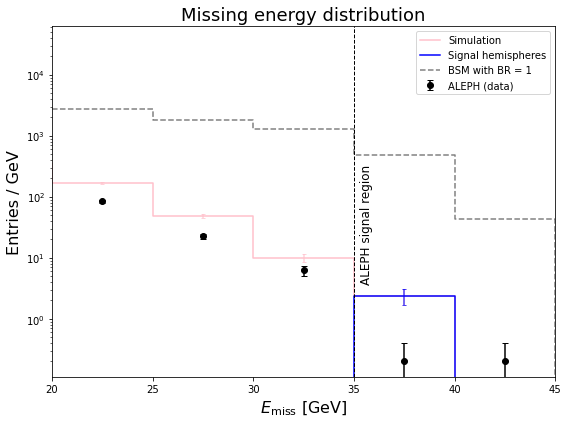

In [61]:
after_cuts_distributionBSM("summary_aleph_all.csv", 
                        "summary_alephHE_tail.csv", x_min=20, x_max=45)